In [1]:
import pandas as pd
import numpy as np
import gurobipy as gp
from gurobipy import GRB
import scipy as sp


# read data
df = pd.read_csv('retail_price.csv')
index = ['product_category_name', 'product_id']
column_min = ['unit_price', 'product_score', 'freight_price', 'product_weight_g', 'comp_1', 'ps1', 'comp_2', 'ps2', 'comp_3', 'ps3']
# column_max = []
column_sum = ['customers']

product_category = ['bed_bath_table', 'computers_accessories', 'consoles_games', 'cool_stuff', 'furniture_decor']
                    #,
                    #'garden_tools', 'health_beauty', 'perfumery', 'watches_gifts']

table_min = pd.pivot_table(df, values=column_min, index=index,  aggfunc=np.min)
# table_min = pivot_table(df, values='D', index=index,  aggfunc=np.max)
table_sum = pd.pivot_table(df, values=column_sum, index=index, aggfunc=np.sum)

In [2]:
table = table_min.merge(table_sum, on=index,how='left')
table

comp_1      comp_2      comp_3   
product_category_name product_id                                       
bed_bath_table        bed1         74.000000   39.240000   39.240000  \
                      bed2         74.000000   74.000000   39.240000   
                      bed3         74.000000   84.900000   39.240000   
                      bed4         77.933333   44.154444   39.990000   
                      bed5         89.900000  163.398710   45.950000   
computers_accessories computers1   94.900000   94.900000   77.900000   
                      computers2  114.491154  109.900000   77.900000   
                      computers3  139.990000  134.900000   78.712281   
                      computers4  114.491154  139.990000   77.900000   
                      computers5  114.491154  119.900000   77.900000   
                      computers6  114.491154  149.900000   77.900000   
consoles_games        consoles1    19.900000   19.900000   19.900000   
                      consoles2    19.900000   19.900000   19.900000   
cool_stuff            cool1        85.704286   85.704286   29.500000   
                      cool2        89.863333  116.927500   29.500000   
                      cool3        35.000000   29.500000   29.500000   
                      cool4        89.863333  116.927500   29.500000   
                      cool5        89.863333   99.990000   29.500000   
furniture_decor       furniture1   38.400000   35.000000   38.400000   
                      furniture2   69.900000   35.000000   75.000000   
                      furniture3   38.400000   35.000000   38.400000   
                      furniture4   69.900000   35.000000   78.535714   
garden_tools          garden1      49.900000   49.900000   49.900000   
                      garden10     49.900000   49.900000   49.900000   
                      garden2      49.900000   49.900000   49.900000   
                      garden3      49.900000   49.900000   49.900000   
                      garden4      49.900000   49.900000   49.900000   
                      garden5      49.900000   49.900000   49.900000   
                      garden6      49.900000   49.900000   49.900000   
                      garden7      49.900000   49.900000   49.900000   
                      garden8      49.900000   49.900000   49.900000   
                      garden9      49.900000   49.900000   49.900000   
health_beauty         health1      23.397407   79.990000   58.990000   
                      health10     23.990000   79.990000   58.990000   
                      health2      23.397407   79.990000   58.990000   
                      health3      23.990000   79.990000   58.990000   
                      health4      23.990000   79.990000   58.990000   
                      health5      19.990000   79.990000   58.799524   
                      health6      23.990000   79.990000   58.990000   
                      health7      19.990000   64.990000   58.799524   
                      health8      19.990000   79.990000   58.799524   
                      health9      19.990000   19.990000   58.799524   
perfumery             perfumery1   49.990000   56.990000   49.990000   
                      perfumery2   49.990000  116.906667  116.906667   
watches_gifts         watches1    103.792523  105.000000  132.531250   
                      watches2    103.792523  105.000000  132.531250   
                      watches3     78.000000   78.000000  132.531250   
                      watches4    103.792523  105.000000  132.531250   
                      watches5    103.792523  105.000000  132.531250   
                      watches6    103.792523  105.000000  132.531250   
                      watches7    103.792523  105.000000  132.531250   
                      watches8    103.792523  105.000000  132.531250   

                                  freight_price  product_score   
product_category_name product_id                                 
bed_bath_table   

## data / parameters

In [3]:
# Selling & Buying & Rating & Probability of buying
selling = {}
for category in product_category:
    selling[category] = (table.loc[category]['unit_price'].values)

buying = {}
for category in product_category:
    buying[category] = selling[category] * np.random.uniform(0.6,0.7)


rating = {}
for category in product_category:
    rating[category] = (table.loc[category]['product_score'].values)
MAX_RATING = 5.

# Customers
n_customers = {}
for category in product_category:
    n_customers[category] = (table.loc[category]['customers'].sum())

#assume rating is independent from the price
p2={}
for category in product_category:
    p2[category] = (np.exp(-selling[category]*(MAX_RATING - rating[category]) / 100) 
              / np.sum(np.exp(-selling[category]*(MAX_RATING - rating[category])/100)))


In [ ]:


# what % of 'market' customers do we get for each % of discount?




## model

In [11]:
def optimize_with_discount_factor(DISCOUNT_FACTOR):
    # fixed freight cost, can change if needed
    SHIPPING_COST = 5

    # how many customers we have that won't buy unless extra conditions are fufilled
    MARKET_CUSTOMERS = {category: 10000 for category in product_category}
    
    # what % of 'market' customers do we get if we have free shipping
    FREE_SHIPPING_FACTOR = 0.1

    # the budget
    BUDGET = 1e9

    # inventory for each category
    INVENTORY_SPACE = 1e5
    
    m = gp.Model()

    BIGNUM = 1e6 # sum(n_customers.values())

    # decision variables
    stock = {}
    is_chosen = {}
    sold = {}
    discount = {}
    free_shipping = {}

    # initialising decision variables
    for category in product_category:
        I = range(len(selling[category]))
        stock[category] = m.addVars(I,vtype = GRB.INTEGER)
        is_chosen[category] = m.addVars(I, vtype = GRB.BINARY)
        sold[category] = m.addVars(I,vtype = GRB.INTEGER)
        discount[category] = m.addVars(I,vtype=GRB.CONTINUOUS, lb=0.1, ub=1)
        free_shipping[category] = m.addVars(I,  vtype = GRB.BINARY)


    # amount sold and extra customers
    captured_customers = lambda category,i: (
        MARKET_CUSTOMERS[category] * (FREE_SHIPPING_FACTOR * free_shipping[category][i]
                                      + DISCOUNT_FACTOR * discount[category][i])
    )
    amount_sold  = lambda category,i: p2[category][i]* (n_customers[category] + captured_customers(category,i))

    # objective function
    m.setObjective(
        gp.quicksum(gp.quicksum(sold[category][i] * selling[category][i] * (1 - discount[category][i]) 
                                - stock[category][i] * buying[category][i]
                                - sold[category][i] * SHIPPING_COST * free_shipping[category][i]
                    for i in range(len(selling[category]))) for category in product_category),
        GRB.MAXIMIZE
    )

    # Can't store past inventory space
    m.addConstrs( gp.quicksum(stock[category][i] for i in range(len(selling[category]))) <= INVENTORY_SPACE 
                 for category in product_category)

    # Can't buy more than the budget
    m.addConstr(gp.quicksum( gp.quicksum(stock[category][i] * buying[category][i] for i in range(len(selling[category]))) 
                            for category in product_category) <= BUDGET)

    for category in product_category:
        # If a product is stocked, is_chosen is set to be 1 [Change to BIGNUM to remove dependencies on n_customers]
        m.addConstrs(stock[category][i] <= is_chosen[category][i] * BIGNUM
                     for i in range(len(selling[category])))
        # Can't sell more than you have stocked
        m.addConstrs(sold[category][i] <= stock[category][i] for i in range(len(selling[category])))
        # How much we can sell depends on number of customers [Removed is_chosen]
        m.addConstrs(sold[category][i] <= amount_sold(category, i)
                     for i in range(len(selling[category])))
        m.addConstrs((FREE_SHIPPING_FACTOR * free_shipping[category][i]
                                      + DISCOUNT_FACTOR * discount[category][i]) <= 1 for i in range(len(selling[category])))

    m.params.NonConvex = 2
    m.optimize()
    
    
    obj_val = m.objVal

    # get the values of the discount decision variables
    discount_vals = {}
    for category in product_category:
        discount_vals[category] = [discount[category][i].X for i in range(len(selling[category]))]
        
    #get the vlues for stock
    stocks = {}
    for category in product_category:
        stocks[category] = [int(stock[category][i].x) for i in range(len(selling[category]))]

    # create a dictionary that stores the results
    results = {
        "objective_value": obj_val,
        "discount_factor": discount_factor,
        "discount_values": discount_vals,
        "stock": stocks
    }

    return results

In [48]:
# create a list of discount factors to study
discount_factors = np.arange(0, 5, 0.2).tolist()

# create a dictionary to store the results
results_dict = {}

# optimize for each discount factor and store the results
for discount_factor in discount_factors:
    results = optimize_with_discount_factor(discount_factor)
    results_dict[discount_factor] = results

Set parameter NonConvex to value 2
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i7-7500U CPU @ 2.70GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 94 rows, 110 columns and 198 nonzeros
Model fingerprint: 0x75de1cd2
Model has 44 quadratic objective terms
Variable types: 22 continuous, 88 integer (44 binary)
Coefficient statistics:
  Matrix range     [1e-01, 1e+06]
  Objective range  [1e+01, 2e+02]
  QObjective range [1e+01, 3e+02]
  Bounds range     [1e-01, 1e+00]
  RHS range        [1e+00, 1e+09]
Found heuristic solution: objective -0.0000000
Presolve removed 93 rows and 108 columns
Presolve time: 0.37s
Presolved: 2 rows, 3 columns, 5 nonzeros
Found heuristic solution: objective 262709.19873
Variable types: 0 continuous, 3 integer (1 binary)
Found heuristic solution: objective 275616.69186

Root relaxation: objective 2.767640e+05, 2 iterations, 0.00 seconds 


    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 334671.161    0    3 305321.868 334671.161  9.61%     -    0s
     0     0 324623.559    0    2 305321.868 324623.559  6.32%     -    0s
H    0     0                    310883.66282 324623.559  4.42%     -    0s
H    0     0                    310911.84315 324623.559  4.41%     -    0s
     0     0 321815.119    0    2 310911.843 321815.119  3.51%     -    0s
H    0     0                    318788.38934 321815.119  0.95%     -    0s
H    0     0                    318816.56967 321815.119  0.94%     -    0s
H    0     0                    319652.23476 321815.119  0.68%     -    0s
     0     0 321711.755    0    4 319652.235 321711.755  0.64%     -    0s
     0     0 321660.144    0    3 319652.235 321660.144  0.63%     -    0s
     0     0 321639.498    0    3 319652.235 321639.498  0.62%     -    0s
     0     0 321638.055

H   24     7                    353093.59415 353206.300  0.03%   1.7    0s
*   32     1              15    353100.76295 353167.583  0.02%   1.5    0s

Cutting planes:
  RLT: 3

Explored 35 nodes (77 simplex iterations) in 0.28 seconds (0.01 work units)
Thread count was 4 (of 4 available processors)

Solution count 10: 353101 353094 353034 ... 335017

Optimal solution found (tolerance 1.00e-04)
Best objective 3.531007629531e+05, best bound 3.531007629531e+05, gap 0.0000%
Set parameter NonConvex to value 2
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i7-7500U CPU @ 2.70GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 94 rows, 110 columns and 242 nonzeros
Model fingerprint: 0x6ced17d2
Model has 44 quadratic objective terms
Variable types: 22 continuous, 88 integer (44 binary)
Coefficient statistics:
  Matrix range     [1e-01, 1e+06]
  Objective range  [1e+01, 2e

     0     0 401320.917    0    1 396451.439 401320.917  1.23%     -    0s
     0     0 401320.127    0    2 396451.439 401320.127  1.23%     -    0s
     0     0 401319.961    0    2 396451.439 401319.961  1.23%     -    0s
     0     0 401319.890    0    2 396451.439 401319.890  1.23%     -    0s
H    0     0                    401319.88705 401319.890  0.00%     -    0s

Cutting planes:
  RLT: 3

Explored 1 nodes (24 simplex iterations) in 0.21 seconds (0.01 work units)
Thread count was 4 (of 4 available processors)

Solution count 7: 401320 396451 392601 ... -0

Optimal solution found (tolerance 1.00e-04)
Best objective 4.013198870502e+05, best bound 4.013198899246e+05, gap 0.0000%
Set parameter NonConvex to value 2
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i7-7500U CPU @ 2.70GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 94 rows, 110 columns and 242 

     0     0 453741.612    0    3 447151.587 453741.612  1.47%     -    0s
     0     0 453571.091    0    3 447151.587 453571.091  1.44%     -    0s
     0     0 452561.702    0    3 447151.587 452561.702  1.21%     -    0s
     0     0 452300.596    0    3 447151.587 452300.596  1.15%     -    0s
     0     0 452194.812    0    3 447151.587 452194.812  1.13%     -    0s
     0     0 452179.678    0    3 447151.587 452179.678  1.12%     -    0s
     0     0 452172.111    0    3 447151.587 452172.111  1.12%     -    0s
     0     0 452171.243    0    3 447151.587 452171.243  1.12%     -    0s
     0     0 452164.389    0    3 447151.587 452164.389  1.12%     -    0s
     0     0 452139.137    0    3 447151.587 452139.137  1.12%     -    0s
     0     0 452138.608    0    3 447151.587 452138.608  1.12%     -    0s
H    0     0                    450683.59848 452138.608  0.32%     -    0s
     0     2 452089.247    0    2 450683.598 452089.247  0.31%     -    0s
H   18    11             

H   30     5                    485136.24830 485228.355  0.02%   0.7    0s
H   32     3                    485136.62406 485228.355  0.02%   0.7    0s
*   35     3              12    485136.90490 485228.355  0.02%   0.7    0s
H   38     4                    485137.09081 485228.355  0.02%   0.7    0s
H   40     4                    485137.18180 485228.355  0.02%   0.7    0s

Cutting planes:
  MIR: 1
  RLT: 2

Explored 50 nodes (44 simplex iterations) in 0.30 seconds (0.01 work units)
Thread count was 4 (of 4 available processors)

Solution count 10: 485137 485137 485137 ... 485111

Optimal solution found (tolerance 1.00e-04)
Best objective 4.851371818041e+05, best bound 4.851498066343e+05, gap 0.0026%
Set parameter NonConvex to value 2
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i7-7500U CPU @ 2.70GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 94 rows, 110 c


Optimize a model with 94 rows, 110 columns and 242 nonzeros
Model fingerprint: 0x7e522d05
Model has 44 quadratic objective terms
Variable types: 22 continuous, 88 integer (44 binary)
Coefficient statistics:
  Matrix range     [1e-01, 1e+06]
  Objective range  [1e+01, 2e+02]
  QObjective range [1e+01, 3e+02]
  Bounds range     [1e-01, 1e+00]
  RHS range        [1e+00, 1e+09]
Found heuristic solution: objective -0.0000000
Presolve removed 92 rows and 107 columns
Presolve time: 0.17s
Presolved: 6 rows, 6 columns, 16 nonzeros
Presolved model has 1 bilinear constraint(s)
Found heuristic solution: objective 525113.83586
Variable types: 3 continuous, 3 integer (1 binary)

Root relaxation: objective 5.685304e+05, 5 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 568530.431    0    3 525113.836 568530.431  8.27%     -    0s
     0     0

H    0     0                    609788.86888 613675.060  0.64%     -    0s
H    0     0                    609817.04921 613675.060  0.63%     -    0s
     0     0 613588.871    0    2 609817.049 613588.871  0.62%     -    0s
H    0     0                    612471.96884 613588.871  0.18%     -    0s
H    0     0                    612500.14917 613588.871  0.18%     -    0s
H    0     0                    613183.61506 613588.871  0.07%     -    0s
     0     0 613545.777    0    2 613183.615 613545.777  0.06%     -    0s
H    0     0                    613249.91217 613545.777  0.05%     -    0s
H    0     0                    613278.09250 613545.777  0.04%     -    0s
     0     0 613524.229    0    2 613278.092 613524.229  0.04%     -    0s
H    0     0                    613455.71167 613524.229  0.01%     -    0s
H    0     0                    613483.89200 613524.229  0.01%     -    0s

Cutting planes:
  MIR: 1
  RLT: 2

Explored 1 nodes (11 simplex iterations) in 0.25 seconds (0.01 w

Set parameter NonConvex to value 2
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i7-7500U CPU @ 2.70GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 94 rows, 110 columns and 242 nonzeros
Model fingerprint: 0x49b7bc5e
Model has 44 quadratic objective terms
Variable types: 22 continuous, 88 integer (44 binary)
Coefficient statistics:
  Matrix range     [1e-01, 1e+06]
  Objective range  [1e+01, 2e+02]
  QObjective range [1e+01, 3e+02]
  Bounds range     [1e-01, 1e+00]
  RHS range        [1e+00, 1e+09]
Found heuristic solution: objective -0.0000000
Presolve removed 92 rows and 107 columns
Presolve time: 0.16s
Presolved: 6 rows, 6 columns, 16 nonzeros
Presolved model has 1 bilinear constraint(s)
Found heuristic solution: objective 650184.02991
Variable types: 3 continuous, 3 integer (1 binary)

Root relaxation: objective 6.968525e+05, 5 iterations, 0.00 seconds (0.

In [49]:
objective = []
for discount_factor in discount_factors:
    print( results_dict[discount_factor][ "objective_value"])
    
    print( results_dict[discount_factor]["discount_values"])
    objective.append( results_dict[discount_factor][ "objective_value"])

276334.68911044236
{'bed_bath_table': [0.1, 0.1, 0.1, 0.1, 0.1], 'computers_accessories': [0.1, 0.1, 0.1, 0.1, 0.1, 0.1], 'consoles_games': [0.1, 0.1], 'cool_stuff': [0.1, 0.1, 0.1, 0.1, 0.1], 'furniture_decor': [0.1, 0.1, 0.1, 0.1]}
291066.794383394
{'bed_bath_table': [0.1, 0.10009609988150542, 0.1, 0.1, 0.1], 'computers_accessories': [0.1, 0.1, 0.1, 0.1, 0.1001950672263704, 0.1], 'consoles_games': [0.1, 0.10003529672068569], 'cool_stuff': [0.1, 0.1, 0.1, 0.10000000000000002, 0.1], 'furniture_decor': [0.1, 0.10029575660951905, 0.1, 0.10001244466248237]}
306057.88411093276
{'bed_bath_table': [0.1, 0.1, 0.1, 0.1, 0.10006008548467082], 'computers_accessories': [0.1, 0.10012889286291196, 0.1, 0.10009068679293918, 0.1, 0.1], 'consoles_games': [0.1354334470476557, 0.13557064715975223], 'cool_stuff': [0.1, 0.1, 0.1, 0.1, 0.1], 'furniture_decor': [0.1, 0.10000000000000007, 0.1, 0.1]}
321335.4500389601
{'bed_bath_table': [0.10021489192102442, 0.10015261417474448, 0.10014598162571729, 0.1, 0.10

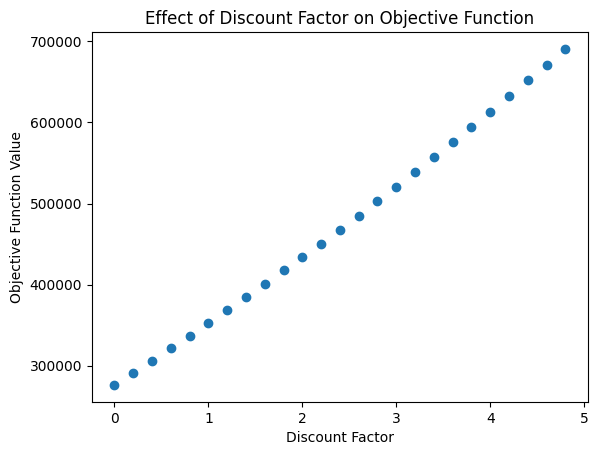

In [51]:
import matplotlib.pyplot as plt

# plot objective function values against discount factors
plt.scatter(discount_factors, objective)
plt.xlabel("Discount Factor")
plt.ylabel("Objective Function Value")
plt.title("Effect of Discount Factor on Objective Function")

plt.show()


AttributeError: module 'matplotlib' has no attribute 'get_data_path'

{'bed_bath_table': {0: <gurobi.Var C0 (value 2956.0)>,
  1: <gurobi.Var C1 (value 1939.0)>,
  2: <gurobi.Var C2 (value 1034.0)>,
  3: <gurobi.Var C3 (value 3074.0)>,
  4: <gurobi.Var C4 (value 1642.0)>},
 'computers_accessories': {0: <gurobi.Var C25 (value 2294.0)>,
  1: <gurobi.Var C26 (value 1384.0)>,
  2: <gurobi.Var C27 (value 1537.0)>,
  3: <gurobi.Var C28 (value 1782.0)>,
  4: <gurobi.Var C29 (value 1400.0)>,
  5: <gurobi.Var C30 (value 1559.0)>},
 'consoles_games': {0: <gurobi.Var C55 (value 4596.0)>,
  1: <gurobi.Var C56 (value 4330.0)>},
 'cool_stuff': {0: <gurobi.Var C65 (value 1845.0)>,
  1: <gurobi.Var C66 (value 1616.0)>,
  2: <gurobi.Var C67 (value 3069.0)>,
  3: <gurobi.Var C68 (value 725.0)>,
  4: <gurobi.Var C69 (value 2025.0)>},
 'furniture_decor': {0: <gurobi.Var C90 (value 2795.0)>,
  1: <gurobi.Var C91 (value 2349.0)>,
  2: <gurobi.Var C92 (value 2909.0)>,
  3: <gurobi.Var C93 (value 2755.0)>}}

1404472.003035212
